###**<div style="text-align: center"> Projet Deep Neural Networks ZRIBI-JABER**


---







On commence par connecter le notebook à la base de données enregistrée dans le drive :

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Par la suite on importe et installe les librairies nécessaires au fonctionnement de nos algotithmes. En particulier, on télécharge et on installe la librairies *cupy*, pour pouvoir utiliser la carte graphique des serveurs de Google. Ce choix a été fait pour limiter le temps d'exécution.

In [2]:
!pip install python-mnist
!pip install cupy
import random
from scipy.io import loadmat
import numpy as np
import math
from matplotlib import pyplot as plt
import mlxtend.data  
import random
from mnist import MNIST
import cupy as cp
import copy

  Created wheel for python-mnist: filename=python_mnist-0.6-py2.py3-none-any.whl size=11660 sha256=abd9ce7d2359b89dd36149133dcf75a8de0d49a55fd898beec44cfc88cb4ad19
  Stored in directory: /root/.cache/pip/wheels/28/29/36/408f83545a511c43d03ef997a1dc99b49ccd5f9f306ed92468
Successfully built python-mnist
     |████████████████████████████████| 3.7MB 3.1MB/s 
  Created wheel for cupy: filename=cupy-7.1.1-cp36-cp36m-linux_x86_64.whl size=28360129 sha256=4efac27a84cc57143c856938f991fe3d7cd8eb1c5df6e2f85f2709dfca4ce584
  Stored in directory: /root/.cache/pip/wheels/72/63/2a/7635c93abc95360cfa1d8a77b6e5e70e2701b593668350c81a
Successfully built cupy


**3.1. Construction D'un RBM et test sur Binary AlphaDigits**

On définit une fonction pour la lecture et la séléction de la partie concernée de la base de données à utiliser : 

In [0]:
## verifiée
def lire_alpha_digit(donnees,liste_carac):
    matrix=[]
    count=0
    for k in range(len(liste_carac)):
        if liste_carac[k].isdigit():
            for i in range(len(donnees[int(liste_carac[k])])):
                donnees[int(liste_carac[k])][i] = np.expand_dims(donnees[int(liste_carac[k])][i].flatten(), axis=0)
            for j in range(len(np.concatenate(donnees[int(liste_carac[k])], axis=0))):
                matrix.append(np.concatenate(donnees[int(liste_carac[k])], axis=0)[j])
                
        if liste_carac[k].isalpha():
            for i in range(len(donnees[ord(liste_carac[k])-87])):
                donnees[ord(liste_carac[k])-87][i] = np.expand_dims(donnees[ord(liste_carac[k])-87][i].flatten(), axis=0)
            for j in range(len(np.concatenate(donnees[ord(liste_carac[k])-87], axis=0))):
                matrix.append(np.concatenate(donnees[ord(liste_carac[k])-87], axis=0)[j])
                
    return np.array(matrix)

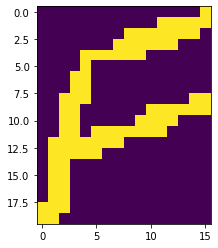

In [7]:
a=loadmat("/content/drive/My Drive/binaryalphadigs.mat")['dat']
b=lire_alpha_digit(a,"f")
plt.imshow(b[30,:].reshape(20,16))

On définit une fonction pour la construction de la structure **RBM**. On crée ainsi une nouvelle classe à partir de la taille=[p,q]. Cette classe a les attribus listés ci-dessous :

In [0]:
## verifiée
def init_RBM(p,q):
    class RBM:
        W = cp.random.normal(0,0.1 ,[p,q])
        a = cp.zeros([1,p])
        b = cp.zeros([1,q])
    r = RBM()
    return r

La définition de la fonction mathématique suivante est nécessaire pour la transformation des données à l'aide de notre RBM.

In [0]:
## verifiée
def sigmoid(x):
  return 1 / (1 + cp.exp(-x))

L'application de notre RBM à notre base de donnée se faire à travers ces 2 fonctions : 

In [0]:
## verifiée
def entree_sortie_RBM(RBM, donnees_entree):
    donnees_sortie=sigmoid(RBM.b+cp.dot(donnees_entree,RBM.W))
    return donnees_sortie    

In [0]:
## verifiée
def sortie_entree_RBM(RBM, donnees_sortie):
    donnees_entree= sigmoid(RBM.a +cp.dot(donnees_sortie,cp.transpose(RBM.W)))
    return donnees_entree

L'entraînement de notre RBM de façon non supervisée, se fait à l'aide de la fonction définie ci-dessous : 

In [0]:
def train_RBM(RBM,nb_iter,alpha,batch_size,donnee_entree):
    n=len(donnee_entree)
    p=RBM.W.shape[0]
    q=RBM.W.shape[1]
    rmse= []
    for i in range(nb_iter):
        x=donnee_entree
        for batch in range(1,n,batch_size):
            #print(n," ",min(n,batch_size+batch-1)," ",batch)
            v0=x[batch:min(n,batch_size+batch-1),:]
            p_h_v0=entree_sortie_RBM(RBM,v0)
          
            h0=1*(cp.random.rand(v0.shape[0],q) <= p_h_v0)
                  
            p_v_h0=sortie_entree_RBM(RBM,h0)
                  
            v1= 1*(cp.random.rand(v0.shape[0],p) <= p_v_h0)
            p_h_v1=entree_sortie_RBM(RBM,v1)
                  
            da= v0.sum(axis=0) - v1.sum(axis=0)
            db = p_h_v0.sum(axis=0) - p_h_v1.sum(axis=0)
            dw = np.dot(cp.transpose(v0),p_h_v0) - cp.dot(cp.transpose(v1),p_h_v1)
                  
            RBM.W += (alpha/len(v0))*dw
            RBM.a += (alpha/len(v0))*da
            RBM.b += (alpha/len(v0))*db
                  
      
        h = entree_sortie_RBM(RBM,x)
        V_construit= sortie_entree_RBM(RBM,h)
        erreur = (x - V_construit)**2
        rmse.append(math.sqrt(np.sum(erreur)/cp.size(erreur)))
        
        
    plt.title("Évolution de la racine de l'erreur quadratique moyenne en fonction du nombre d'itérations")
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Racine de l'erreur quadratique moyenne")
    plt.plot(list(range(nb_iter)),rmse)
    plt.show()
    
        
    return (RBM)

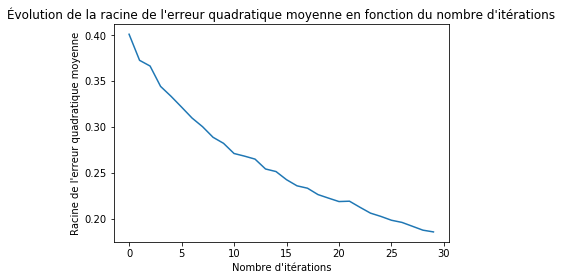

In [66]:
b = lire_alpha_digit(a,['0'])
RBM = init_RBM(320,200) 
RBM1= train_RBM(RBM,30,0.1,8,cp.asarray(b))

On pourra essayer de générer des images semblables à celles apprises à travers la fonction suivante : 

In [0]:
def generer_image_RBM(RBM,nb_iter,nb_image):
    
    p=RBM.W.shape[0]
    q=RBM.W.shape[1]
    
    # Initialisation aléatoire d'images
    V0 = 1*(cp.random.rand(nb_image,320)<= 0.5)
    
    for i in range(nb_iter):
        
        p_h_v0 = entree_sortie_RBM(RBM,V0)
    
        H0 = 1*(cp.random.rand(nb_image,q) <= p_h_v0)
        p_v_h0 = sortie_entree_RBM(RBM,H0)
    
        V1 = 1*(cp.random.rand(nb_image,p) <= p_v_h0)
    
        V0 = V1
    
  
    
    return(V0)

ValueError: ignored

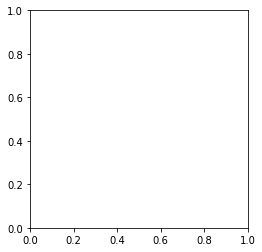

In [36]:
images = generer_image_RBM(RBM1,50,4)
for i in range(4):
   plt.imshow(images[i].reshape(20,16))

**3.2. Construction d'un DBN et test sur Binary AlphaDigits**

On crée un DNN, en utilisant la même logique pour la création du RBM. Mais en considérant que ce dernier est un empilement de RBM. Ainsi le résultat s'affiche ainsi :

In [0]:
def init_DNN(taille):  
    w=[]
    a=[]
    b=[]
    for i in range(len(taille)-1):
        #print(i)
        w.append(cp.random.normal(0,0.1,[taille[i],taille[i+1]]))
       # print(w)
        a.append(cp.zeros([1,taille[i]]))
        b.append(cp.zeros([1,taille[i+1]]))
    class DNN:
        W=w
        A=a
        B=b
    d = DNN()
    return d

Pour entrainer le DBN d'une manière non supervisé, on procéde par un entrainement couche par couche. On considère que chaque est un RBM qui doit être entrainé à l'aide de la fonction *train_RBM*, sa sortie va ensuite être l'entrée de la couche suivante et ainsi de suite. 

In [0]:
def train_DBN(DNN,nb_iter,alpha,batch_size,donnee_entree):
    L=len(DNN.W)
    for i in range(L-1):
        p=DNN.W[i].shape[0]
        q=DNN.W[i].shape[1]
        RBM=init_RBM(p,q)
        if (i==0):
            H = donnee_entree
            RBM1 = train_RBM(RBM,nb_iter,alpha,batch_size,H);
            DNN.W[i] = RBM1.W
            DNN.A[i] = RBM1.a
            DNN.B[i] = RBM1.b
            H = entree_sortie_RBM(RBM,H)
        else:
          RBM.W = DNN.W[i]
          RBM.a = DNN.A[i]
          RBM1 = train_RBM(RBM,nb_iter,alpha,batch_size,H)
          DNN.W[i] = RBM1.W
          DNN.B[i] = RBM1.b
          H = entree_sortie_RBM(RBM,H)
    return DNN

In [39]:
dnn0 = init_DNN([320,200,200,300,200])
dnn_trained = train_DBN(dnn0,50,0.1,8,b)

KeyError: ignored

La génération d'images est toujours nécessaire pour vérifier l'apprentissage non supervisé : 

In [0]:
def generer_image_DBN(DNN,nb_iter,nb_image):
    p = DNN.B[0].shape[0]
    q = DNN.B[-1].shape[1]
    #print("q= ",q)
    # Initialisation aléatoire d'images
    V0 = 1*(cp.random.rand(nb_image,320)<= 0.5)
    L = len(DNN.W)  
    for i in range(nb_iter):  
        for j in range(L):
            (p1,q1) = DNN.W[j].shape
            RBM = init_RBM(p1,q1)
            RBM.W = DNN.W[j]
            RBM.a = DNN.B[j]
            RBM.b = DNN.B[j+1]
            V0 = entree_sortie_RBM(RBM,V0)
            #print(V0.shape," ",j," ",RBM.W.shape)
            
            
        p_h_v0 = V0
    
        H0 = 1*(cp.random.rand(nb_image,q) <= p_h_v0)
        for k in range(L-1,-1,-1):
            p1= DNN.W[k].shape[0]
            q1= DNN.W[k].shape[1]
            RBM = init_RBM(p1,q1)
            RBM.W = DNN.W[k]
            RBM.a = DNN.B[k]
            RBM.b = DNN.B[k+1]
            H0 = sortie_entree_RBM(RBM,H0)
    
        p_v_h0 = H0
    
        V1 = 1*(cp.random.rand(nb_image,p) <= p_v_h0)
    
        V0 = V1
  
   
    
    return(V0)

In [0]:
Images_DNN = generer_image_DBN(dnn_trained,50,6)
 for i in range(6):
        img = cp.reshape(Images_DNN[i],(20, 16))
        plt.imshow(img)
        plt.show()

**3.3. Construction d'un DNN et test sur MNIST**

Pour la prise de décision au niveau de la sortie de notre réseau de RBM, une fonction de calcul de probabilité est nécessaire : 

In [0]:
def softmax(x):
    return cp.exp(x)/cp.exp(x).sum(axis=1,keepdims = True)

In [0]:
def calcul_softmax(RBM,donnee_entree):
    #print(donnee_entree.shape," ",RBM.W.shape)
    return softmax(cp.dot(donnee_entree,RBM.W)+RBM.b)

La sortie de chaque couche de notre réseau de RBMs se calcule ainsi : 

In [0]:
def entree_sortie_reseau(DNN,X):
    sortie=[]
    n=len(DNN.W)
    entree=X.copy()
    for i in range(n-1):
       RBM=init_RBM(DNN.W[i].shape[0],DNN.W[i].shape[1])   
       RBM.W=DNN.W[i]
       RBM.a=DNN.A[i]
       RBM.b=DNN.B[i]
       sortie.append(entree_sortie_RBM(RBM,entree))
       entree=sortie[i]
    RBM = init_RBM(DNN.W[n-1].shape[0],DNN.W[n-1].shape[1])
    RBM.W = DNN.W[n-1]
    RBM.a = DNN.A[n-1]
    RBM.b = DNN.B[n-1]
    sortie.append(calcul_softmax(RBM,entree))

    return (sortie)

In [0]:
def retropropagation(dnn,nb_iter,alpha,batch_size,donnee_entree,y):
    
    # suivi de l'entropie croisée
    cross_entropie = []
    err=[]
    #print(donnee_entree)
    
    L = len(dnn.W) #nombre de couche
    n = donnee_entree.shape[0]
    p = donnee_entree.shape[1]

    # Transformation des labels en représentation binaire
    y_binary = cp.zeros([n,10])

    taille=[]
    for k in range(len(dnn.W)):
      taille.append(dnn.W[k].shape[0])
    taille.append(dnn.W[k].shape[1])
    D = init_DNN(taille)
    D.W=dnn.W.copy()
    D.A=dnn.A.copy()
    D.B=dnn.B.copy()
    for i in range(n):
        y_binary[i][y[i]] = 1        
    
    for i in range(nb_iter): 
        
        donnee_entree_copy = donnee_entree.copy()
        y_copy = y.copy()
        y_binary_copy = y_binary.copy()
       
        #print(i)
        
        for j in range(0,n,batch_size): #(0,n,batch_size)
            

            taille=[]
            for k in range(len(dnn.W)):
              taille.append(dnn.W[k].shape[0])
            taille.append(dnn.W[k].shape[1])
            train_dnn = init_DNN(taille)
            train_dnn.W=D.W.copy()
            train_dnn.A=D.A.copy()
            train_dnn.B=D.B.copy()
            #print(j," ",train_dnn.W[L-1][5][3]," ",dnn.W[L-1][5][3])
            donnees=donnee_entree_copy[j:min(j+batch_size-1,n),:]
            labels=y_binary_copy[j:min(j+batch_size-1,n),:]
            sortie=entree_sortie_reseau(train_dnn,donnees)
            #print(cp.argmax(sortie[len(sortie)-1],axis=1))
            sortie2=sortie[-1]

            for l in range(L,0,-1): #(L,0,-1)
                if (l == 1):
                  h=donnees
                else :
                  h=sortie[l-2]  

                if l==L:
                  C=sortie[l-1]-labels
                else : 
                  C1=cp.dot(C,train_dnn.W[l].T) 
                  term_term_1=sortie[l-1]*(1-sortie[l-1])
                  term_term_2=C1*term_term_1
                  C=term_term_2
                
        
                dW=cp.dot(h.T,C)
                dB=cp.sum(C,axis=0)
                #print(k)
                #print(C.shape," ",dB.shape," ",dnn.B[l-1].shape)
                D.W[l-1] = D.W[l-1] - (alpha/batch_size)*dW
                D.B[l-1] = D.B[l-1] - (alpha/batch_size)*dB 
               


            #print(C," j= ",j," i= ",i)
                     
            
            
            Y_predit=entree_sortie_reseau(dnn,donnee_entree_copy)[L-1]
            log_Y_predit=cp.log(Y_predit)
            log_Yp=cp.asarray(log_Y_predit)
            cross_entropie.append( cp.mean(cp.sum(-log_Yp, axis=1)))
    
    return(train_dnn,cross_entropie)

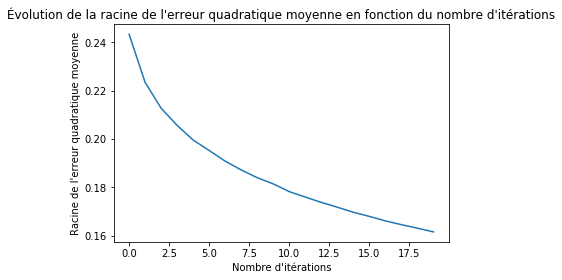

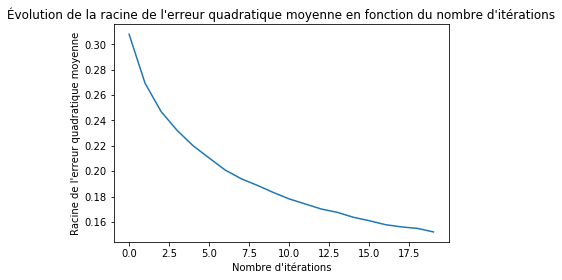

array(0.02020202)

In [79]:
DNN2=init_DNN([784,200,200,10])
dnn_train2=train_DBN(DNN2,nb_iter,alpha,batch_size,Data[1:1000])
#print(Data)
DNN2_retro=retropropagation(dnn_train2,30,0.1,batch_size,Data[1:10000],L[1:10000])[0]
err=test_DNN(DNN2_retro,Data_test[1:100],L_test[1:100])
err

In [0]:
def test_DNN(DNN,donnee_test,label_test):
    sortie=entree_sortie_reseau(DNN,donnee_test)
    label_estimé=cp.argmax(sortie[len(sortie)-1],axis=1)
    R=cp.asarray(label_test)- label_estimé
    taux_erreur =cp.count_nonzero(R)/len(R)
    return(taux_erreur)

**4. Travail préliminaire (Binary AlphaDigit)**

On charge les données qu'on va utiliser pour l'entraînement et le test de notre réseau DNN. On essaye aussi de visualiser aléatoirement 2 éléments de la base de données avec leurs labels pour vérifier leurs cohérence : 

In [48]:
mndata = MNIST("/content/drive/My Drive/RBM/")

images_train, labels_train = mndata.load_training()
L=cp.asarray(labels_train)
images_test, labels_test = mndata.load_testing()
index = random.randrange(0, len(images_train))
index1 = random.randrange(0, len(images_test)) # choisir des index aléatoirement ;-)
print(mndata.display(images_train[index]))
print(labels_train[index])
print(mndata.display(images_test[index1]))
print(labels_test[index1]) #tester la correspondance image/label


............................
............................
............................
............................
............................
............................
............................
............................
............@@@@@@@.........
.........@@@.......@........
........@@.........@........
.......@@..........@...@....
.....@@@...........@.@@@....
....@@@............@@@@.....
.....@@...........@@.@@.....
.....@@...........@..@......
.....@@..........@@..@......
......@........@@@..@@......
......@@.....@@@....@.......
........@@@@@......@@.......
...................@........
...................@........
...................@........
...................@........
............................
............................
............................
............................
9

............................
............................
............................
............................
............................
...............@@...........
..........

conversion en noir et blanc : 

In [0]:
Data=cp.where(cp.asarray(images_train)>127,1,0)
Data_test=cp.where(cp.asarray(images_test)>127,1,0)

Préparation de l'environnement d'éxcécution de notre réseau : 

In [0]:
batch_size=50
nb_iter=20
alpha=0.1
L_test=labels_test

**5. Analyse**

La variation de l'accuration en fonction du nombre de couches : 

Nombre de couches :  2
Fin initiation


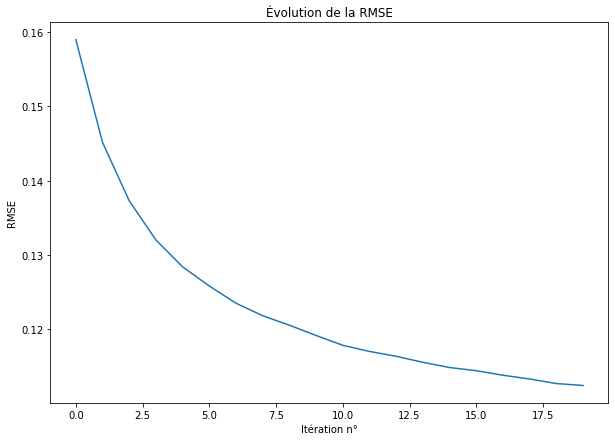

Fin train


KeyboardInterrupt: ignored

In [59]:

#figure 1 

err1=[]
err2=[]
for k in range(2,7):
    taille=[]
    taille.append(784)
    print("Nombre de couches : ",k)
    for i in range(1,k):
        taille.append(200)
    taille.append(10)
    DNN1=init_DNN(taille)
    DNN2=init_DNN(taille)
    print("Fin initiation")
    DNN1_trained=train_DBN(DNN1,nb_iter,alpha,batch_size,Data)
    print("Fin train")
    DNN1_trained_retro=retropropagation(DNN1_trained,nb_iter,alpha,batch_size,Data,L)[0]
    DNN2_trained_retro=retropropagation(DNN2,nb_iter,alpha,batch_size,Data,L)[0]
    print("fin retro")
    err1.append(test_DNN(DNN1_trained_retro,Data_test,L_test))
    err2.append(test_DNN(DNN2_trained_retro,Data_test,L_test))
    print("err1: ", err1)
    print("err2: ", err2)
    print("fin test")
    

In [0]:
plt.title("Évolution du taux d'erreur de prédiction du label en fonction du nombre de couches cachées pour 10 000 données d'entraînement")
plt.xlabel("Nombre de couches cachées")
plt.ylabel("Taux d'erreur de la prédiction")
plt.plot(range(1,6),err1,'r',label='DBN pré-entraîné')
plt.plot(range(1,6),err2,'b',label='DBN non pré-entraîné')
plt.legend(loc="upper right")
plt.show()

Fin initiation


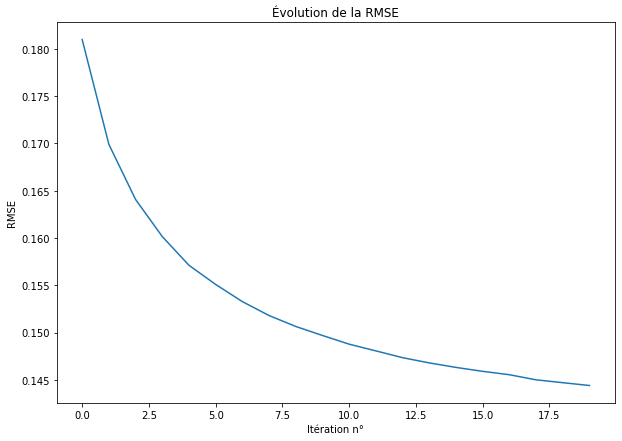

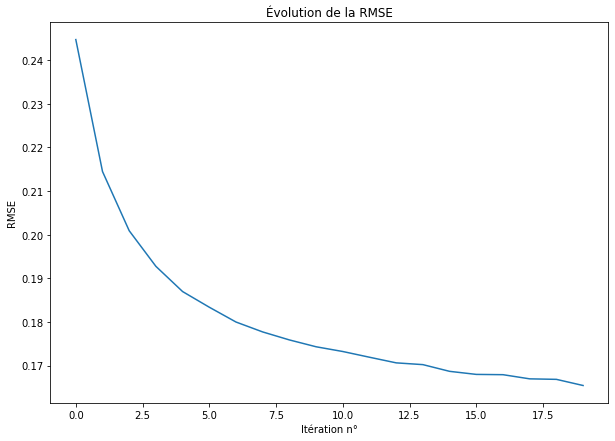

Fin train
fin retro
Accuracy1:  [array(0.9583)]
Accuracy2:  [array(0.964)]
fin test
Fin initiation


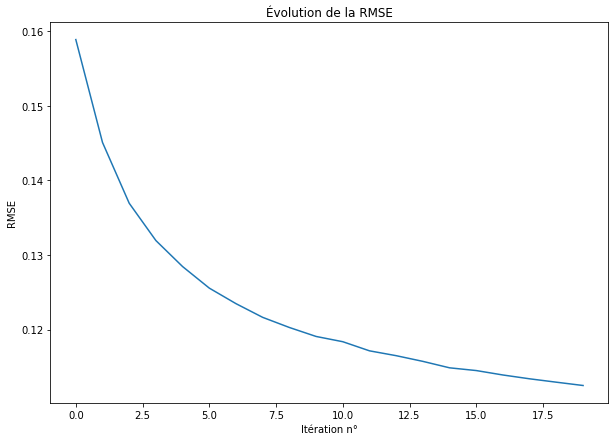

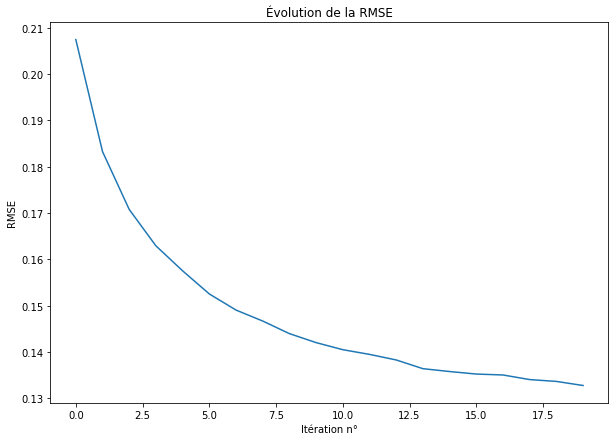

Fin train
fin retro
Accuracy1:  [array(0.9583), array(0.9692)]
Accuracy2:  [array(0.964), array(0.963)]
fin test
Fin initiation


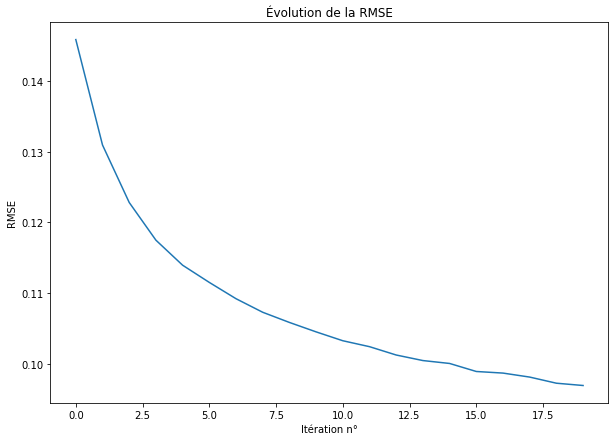

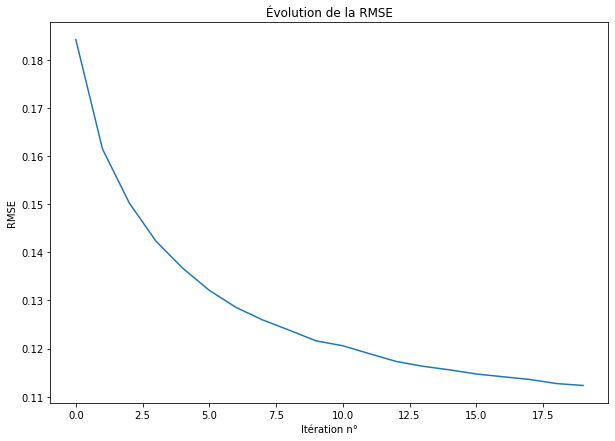

Fin train
fin retro
Accuracy1:  [array(0.9583), array(0.9692), array(0.9729)]
Accuracy2:  [array(0.964), array(0.963), array(0.9625)]
fin test
Fin initiation


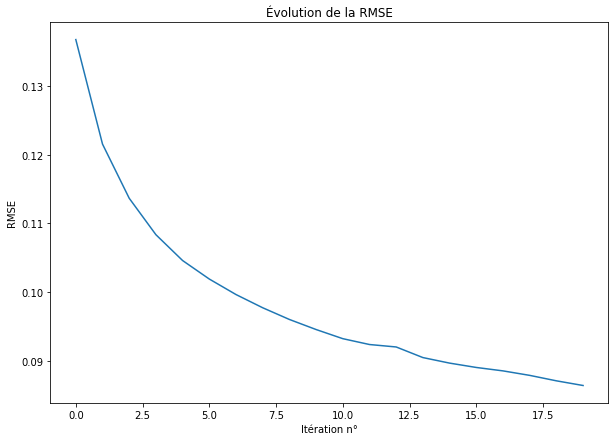

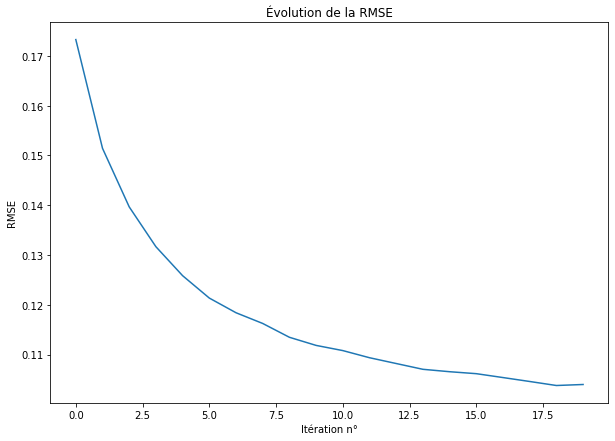

Fin train
fin retro
Accuracy1:  [array(0.9583), array(0.9692), array(0.9729), array(0.9736)]
Accuracy2:  [array(0.964), array(0.963), array(0.9625), array(0.9621)]
fin test
Fin initiation


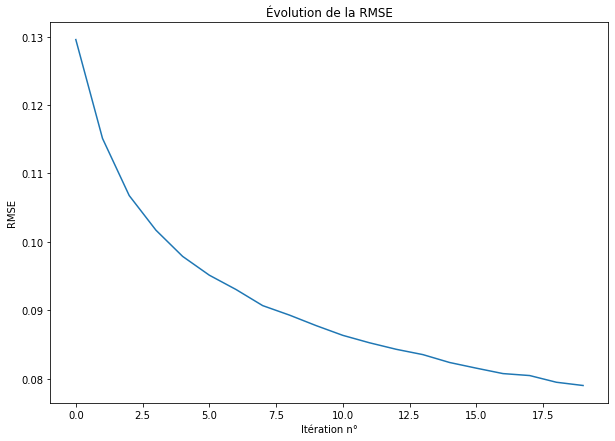

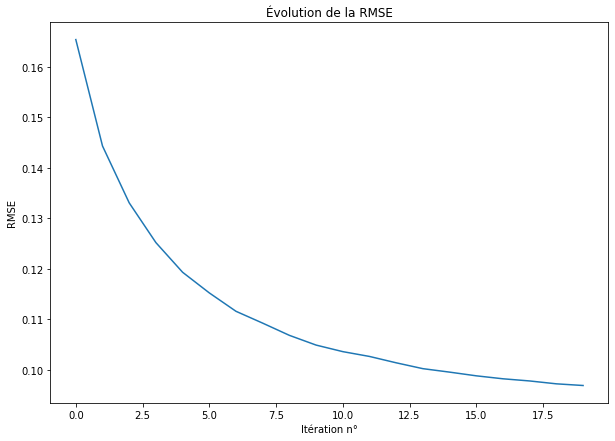

Fin train
fin retro
Accuracy1:  [array(0.9583), array(0.9692), array(0.9729), array(0.9736), array(0.9736)]
Accuracy2:  [array(0.964), array(0.963), array(0.9625), array(0.9621), array(0.9616)]
fin test
Fin initiation


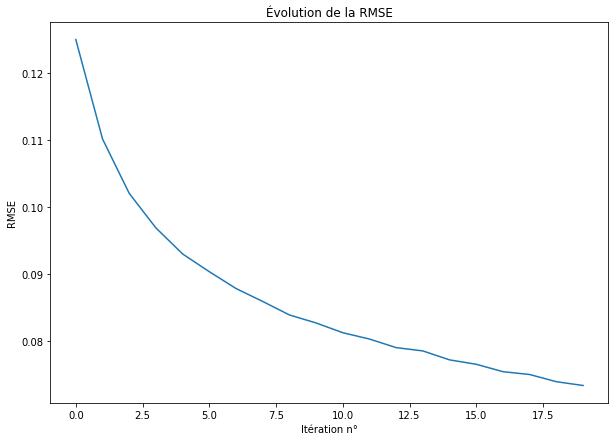

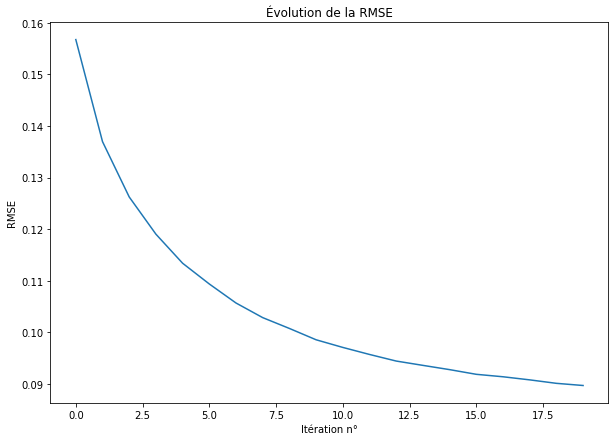

Fin train
fin retro
Accuracy1:  [array(0.9583), array(0.9692), array(0.9729), array(0.9736), array(0.9736), array(0.9755)]
Accuracy2:  [array(0.964), array(0.963), array(0.9625), array(0.9621), array(0.9616), array(0.9623)]
fin test
Fin initiation


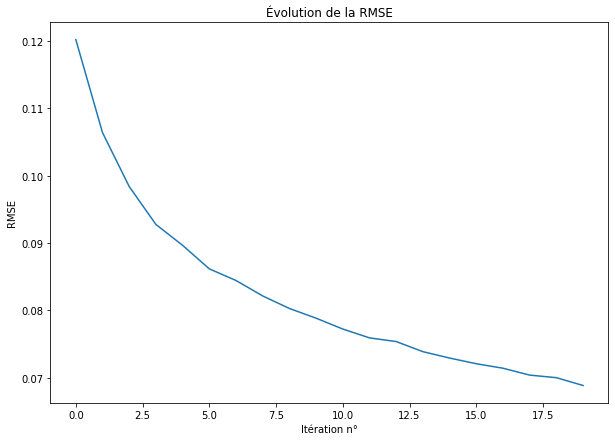

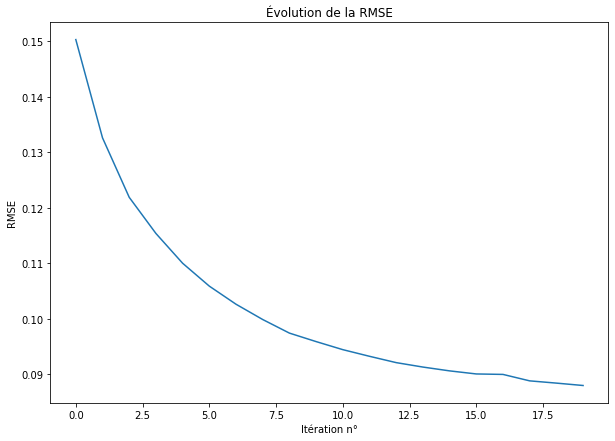

Fin train


KeyboardInterrupt: ignored

In [55]:
#figure 2

err1_couche=[]
err2_couche=[]

for k in range(1,8):
    taille=[784,k*100,k*100,10]
    DNN1=init_DNN(taille)
    DNN2=init_DNN(taille)
    print("Fin initiation")
    DNN1_trained=train_DBN(DNN1,nb_iter,alpha,batch_size,Data)
    print("Fin train")
    DNN1_trained_retro=retropropagation(DNN1_trained,nb_iter,alpha,batch_size,Data,L)[0]
    DNN2_trained_retro=retropropagation(DNN2,nb_iter,alpha,batch_size,Data,L)[0]
    print("fin retro")
    err1_couche.append(test_DNN(DNN1_trained_retro,Data_test,L_test))
    err2_couche.append(test_DNN(DNN2_trained_retro,Data_test,L_test))
    print("err1: ", err1_couche)
    print("err2: ", err2_couche)
    print("fin test")
    

In [0]:
plt.title("Évolution du taux d'erreur de prédiction du label en fonction du nombre de neurones dans nos deux couches cachées pour 60 000 données d'entraînement")
plt.xlabel("Nombre de neurones dans nos deux couches cachées")
plt.ylabel("Taux d'erreur de la prédiction")
plt.plot(range(100,700,100),err1_couche,'r',label='DBN pré-entraîné')
plt.plot(range(100,700,100),err2_couche,'b',label='DBN non pré-entraîné')
plt.legend(loc="upper right")
plt.show()

In [58]:
#figure 3

err1_data=[]
err2_data=[]
Nb_data=[1000,3000,7000,10000,30000,60000]

for k in range(5):
    taille=[784,200,200,10]
    Data1=Data[1:Nb_data[k]]
    L1=L[1:Nb_data[k]]
    DNN1=init_DNN(taille)
    DNN2=init_DNN(taille)
    print("Fin initiation")
    DNN1_trained=train_DBN(DNN1,nb_iter,alpha,batch_size,Data1)
    print("Fin train")
    DNN1_trained_retro=retropropagation(DNN1_trained,nb_iter,alpha,batch_size,Data1,L1)[0]
    DNN2_trained_retro=retropropagation(DNN2,nb_iter,alpha,batch_size,Data1,L1)[0]
    print("fin retro")
    err1_data.append(test_DNN(DNN1_trained_retro,Data_test,L_test))
    err2_data.append(test_DNN(DNN2_trained_retro,Data_test,L_test))
    print("err1: ", err1_data)
    print("err2: ", err2_data)
    print("fin test")

Fin initiation
Fin train
fin retro
Accuracy1:  []
Accuracy2:  [array(0.9641)]
fin test


In [0]:

plt.title("Évolution du taux d'erreur de prédiction du label en fonction du nombre de données utilisées")
plt.xlabel("Nombre de données utilisée")
plt.ylabel("Taux d'erreur de la prédiction")
plt.plot(Nb_data,err1_data,'r',label='DBN pré-entraîné')
plt.plot(Nb_data[0:len(Nb_data)-1],err2_data,'b',label='DBN non pré-entraîné')
plt.legend(loc="upper right")
plt.show()